In [43]:
%load_ext autoreload
%autoreload 2

import torch 
import os
import glob
from matplotlib import pyplot as plt
import os
import torch
import numpy as np
# Cd to code
import os
import sys
os.chdir('/cluster/home/kheuto01/code/prob_diff_topk')
sys.path.append('/cluster/home/kheuto01/code/prob_diff_topk')


from distributions import ZeroInflatedDist, QuantizedNormal
from torch_models import MixtureOfTruncNormModel
from torch_training import train_epoch
from torch_perturb.torch_pert_topk import PerturbedTopK

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
S = 23
T = 300
seed=360
K=3

In [45]:
low_set_1_10 = [QuantizedNormal(10, 0.3) for _ in range(10)]
low_set_2_10 = [QuantizedNormal(30, 0.3) for _ in range(10)]
high_set_3 = [QuantizedNormal(50,3) for _ in range(3)]

dist_S = low_set_1_10 + low_set_2_10 + high_set_3

y_TS = np.zeros((T, S))
for s, dist in enumerate(dist_S):
    random_state = np.random.RandomState(10000 * seed + s*123456)
    y_TS[:, s] = dist.rvs(size=T, random_state=random_state)

(array([2.69420290e-01, 1.19096334e-02, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.33162830e-02, 2.51884058e-01, 1.61295823e-02, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.87553282e-04, 5.62659847e-04, 2.53196931e-03, 6.75191816e-03,
        5.62659847e-03, 1.95055413e-02, 1.13469736e-02, 1.96930946e-02,
        6.93947144e-03, 8.34612106e-03, 1.87553282e-03, 9.37766411e-04,
        9.37766411e-05]),
 array([ 9.        , 10.54545455, 12.09090909, 13.63636364, 15.18181818,
        16.72727273, 18.27272727, 19.81818182, 21.36363636, 22.90909091,
        24.45454545, 26.        , 27.54545455, 29.09090909, 30.63636364,
        32.18181818, 33.72727273, 35.27272727, 36.81818182, 38.36363636,
        39.90909091, 41.45454545, 43.        , 44.54545455, 46.09090909,
        47.63636364, 49.18181818,

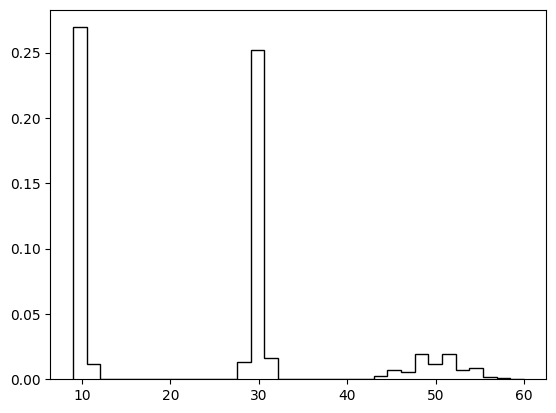

In [6]:
plt.hist(y_TS.flatten(), density=True, bins=33, histtype='step', color='black')

In [46]:
correct_model = MixtureOfTruncNormModel( num_components=3, S=S, low=0, high=100)
step_size = 0.005
optimizer = torch.optim.Adam(correct_model.parameters(), lr=step_size)

perturbed_top_K_func = PerturbedTopK(k=K)

In [47]:
# take inverse softplus
ideal_means = torch.tensor([10, 30, 50])
ideal_softinv_means = ideal_means + torch.log(-torch.expm1(-ideal_means))
ideal_scales = torch.tensor([0.3, 0.3, 3])
ideal_softinv_scales = ideal_scales - 0.2 + torch.log(-torch.expm1(-ideal_scales + 0.2)) 
ideal_mix_weights = torch.log(1e-13 + torch.tensor(
                                [[1,0,0]*10+[0,1,0]*10+[0,0,1]*3]))

In [7]:
correct_model.update_params(torch.cat([ideal_softinv_means, ideal_softinv_scales, ideal_mix_weights.view(-1)]))

In [8]:
loss, bpr, nll, _ =  train_epoch(correct_model,optimizer, K, 0.9, T, 200, 200, torch.tensor(y_TS), perturbed_top_K_func, 1, 1, update=False)

/cluster/home/kheuto01/code/prob_diff_topk/torch_training.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  positive_bpr_T = torch_bpr_uncurried(ratio_rating_TS, torch.tensor(train_y_TS), K=K, perturbed_top_K_func=perturbed_top_K_func)
/cluster/home/kheuto01/code/prob_diff_topk/torch_training.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = torch.sum(-mix_model.log_prob( torch.tensor(train_y_TS)))


det bpr: 1.0
nll: 3626.924685230779
Loss: 3687.1634749887885


/cluster/home/kheuto01/code/prob_diff_topk/torch_training.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  deterministic_bpr_T = deterministic_bpr(ratio_rating_TS, torch.tensor(train_y_TS), K=K)


In [9]:
mis_nll_model = MixtureOfTruncNormModel( num_components=2, S=S, low=0, high=100)

In [10]:
# take inverse softplus
mis_nll_means = torch.tensor([10,37])
mis_nll_softinv_means = mis_nll_means + torch.log(-torch.expm1(-mis_nll_means))
mis_nll_scales = torch.tensor([0.3,5])
mis_nll_softinv_scales = mis_nll_scales - 0.2 + torch.log(-torch.expm1(-mis_nll_scales + 0.2)) 
mis_nll_mix_weights = torch.log(1e-13 + torch.tensor(
                                [[1,0]*10+[0,1]*13]))

In [11]:
 mis_nll_model.update_params(torch.cat([mis_nll_softinv_means, mis_nll_softinv_scales, mis_nll_mix_weights.view(-1)]))

In [12]:
_ = train_epoch(mis_nll_model,optimizer, K, 0.9, T, 200, 200, torch.tensor(y_TS), perturbed_top_K_func, 1, 1, update=False)

det bpr: 0.6963447954734631
nll: 16523.952682174706
Loss: 16605.997958313066


In [73]:
mis_bpr_model = MixtureOfTruncNormModel( num_components=2, S=S, low=0, high=100)
optimizer = torch.optim.Adam(mis_bpr_model.parameters(), lr=0.01)

perturbed_top_K_func = PerturbedTopK(k=K,sigma=0.03)

In [74]:
# take inverse softplus
mis_bpr_means = torch.tensor([1, 10])
mis_bpr_softinv_means = mis_bpr_means + torch.log(-torch.expm1(-mis_bpr_means))
mis_bpr_scales = torch.tensor([1, 1])
mis_bpr_softinv_scales = mis_bpr_scales - 0.2 + torch.log(-torch.expm1(-mis_bpr_scales + 0.2)) 
mis_bpr_mix_weights = torch.log(1e-13 + torch.tensor(
                                [[1,0]*20+[0,1]*3]))

In [75]:
mis_bpr_model.update_params(torch.cat([mis_bpr_softinv_means, mis_bpr_softinv_scales, mis_bpr_mix_weights.view(-1)]))

In [76]:
losses, bprs, nlls = [], [], []
for epoch in range(1):
    loss, bpr, nll, mis_bpr_model =train_epoch(mis_bpr_model,optimizer, K, 0.9, T, 200, 200, torch.tensor(y_TS), perturbed_top_K_func, 5000, 0, update=False)
    losses.append(loss)
    bprs.append(bpr)
    nlls.append(nll)

det bpr: 1.0
Pert bpr: 0.9989508490897614
nll: 1431332.6422327673
Loss: 0.0


In [15]:
rating = _[3]

In [16]:
rating[0,:]

tensor([0.0050, 0.0053, 0.0051, 0.0052, 0.0057, 0.0052, 0.0051, 0.0054, 0.0054,
        0.0052, 0.0051, 0.0052, 0.0054, 0.0053, 0.0050, 0.0048, 0.0050, 0.0054,
        0.0049, 0.0051, 0.2984, 0.2986, 0.2992])

In [7]:
base_dir = '/cluster/tufts/hugheslab/kheuto01/synth_103050_4000_comp2'
exps = glob.glob(base_dir + '/*')

In [35]:
for e,exp in enumerate(exps):
    if 'bw100000_nw0_sig0.1_ss0.1_th0.95' not in exp:
        continue
    if e % 10 == 0:
        print(f'Processing {e} / {len(exps)}')

    # extract bw number and new number from model name
    bw = exp.split('bw')[1].split('_')[0]
    nw = exp.split('nw')[1].split('_')[0]
    title = f'BPR Weight: {bw}, NLL Weight: {nw}'
    model = MixtureOfTruncNormModel(num_components=2, S=23)
    model.load_state_dict(torch.load(exp + '/model.pth'))

In [36]:
optimizer = torch.optim.Adam(model.parameters(), lr=.1)
perturbed_top_K_func = PerturbedTopK(k=K, sigma=0.001)

In [41]:
losses, bprs, nlls = [], [], []
for epoch in range(100):
    loss, bpr, nll, model =train_epoch(model, optimizer, K, 0.95, T, 200, 200, torch.tensor(y_TS), perturbed_top_K_func, 1, 0, update=True)
    losses.append(loss)
    bprs.append(bpr)
    nlls.append(nll)

det bpr: 0.6712759593908072
Pert bpr: 0.6763693990945172
nll: 99968.01331581421
Loss: 82.08918027164479


/cluster/home/kheuto01/code/prob_diff_topk/torch_training.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  positive_bpr_T = torch_bpr_uncurried(ratio_rating_TS, torch.tensor(train_y_TS), K=K, perturbed_top_K_func=perturbed_top_K_func)
/cluster/home/kheuto01/code/prob_diff_topk/torch_training.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = torch.sum(-mix_model.log_prob( torch.tensor(train_y_TS)))
/cluster/home/kheuto01/code/prob_diff_topk/torch_training.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  deterministic_bpr_T

det bpr: 0.6700183776474563
Pert bpr: 0.6747370253223147
nll: 101250.79911019052
Loss: 82.57889240330559
det bpr: 0.6689706784368376
Pert bpr: 0.6739307761419828
nll: 102147.63790350105
Loss: 82.82076715740516
det bpr: 0.6782133938027226
Pert bpr: 0.6770232412722506
nll: 103913.15373059502
Loss: 81.89302761832482
det bpr: 0.6806500602218458
Pert bpr: 0.6789550669439118
nll: 104947.44214943076
Loss: 81.31347991682641
det bpr: 0.6885984011360109
Pert bpr: 0.6763781927301905
nll: 105757.76590786448
Loss: 82.08654218094284
det bpr: 0.6708608236961978
Pert bpr: 0.6744504206041001
nll: 106293.64663185335
Loss: 82.66487381876993
det bpr: 0.6684367151357951
Pert bpr: 0.6709452260425741
nll: 107046.58972643645
Loss: 83.71643218722777
det bpr: 0.6664982089212101
Pert bpr: 0.6737152246289035
nll: 107622.18229590938
Loss: 82.88543261132892
det bpr: 0.6746824711346121
Pert bpr: 0.6719626314421094
nll: 108256.34393310972
Loss: 83.41121056736716
det bpr: 0.6730776319579176
Pert bpr: 0.672172578114044

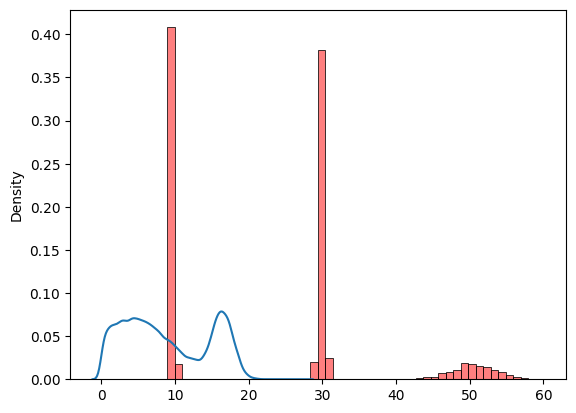

In [38]:
model.plot_learned(data=y_TS)

In [40]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([ 4.1973, 16.5032], requires_grad=True)
Parameter containing:
tensor([5.1569, 0.7686], requires_grad=True)
Parameter containing:
tensor([[ 4.5308, -3.7607],
        [ 2.5041, -1.7894],
        [ 5.1284, -4.4201],
        [ 2.7936, -2.2948],
        [ 4.4773, -3.6502],
        [ 3.3009, -2.6838],
        [-4.0500,  4.8071],
        [-0.5020,  2.1055],
        [ 5.0254, -4.2207],
        [ 4.2166, -3.3222],
        [ 1.6990, -0.9354],
        [ 4.6064, -3.9758],
        [ 3.6540, -3.1826],
        [ 2.3928, -1.9497],
        [ 2.0405, -1.0238],
        [ 3.4338, -1.9969],
        [ 4.0637, -3.3269],
        [-4.8840,  4.8951],
        [ 4.9920, -3.7173],
        [-3.3700,  4.7888],
        [ 2.0726, -0.9000],
        [-2.7463,  4.0786],
        [-4.9934,  5.9771]], requires_grad=True)


In [42]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([ 4.4890, 15.9470], requires_grad=True)
Parameter containing:
tensor([3.7605, 1.1306], requires_grad=True)
Parameter containing:
tensor([[ 4.9086, -4.1385],
        [ 1.9000, -1.1853],
        [ 4.6892, -3.9809],
        [ 1.7027, -1.2039],
        [ 4.6132, -3.7861],
        [ 4.1258, -3.5087],
        [-3.1088,  3.8659],
        [-0.7725,  2.3760],
        [ 5.2340, -4.4293],
        [ 4.6216, -3.7272],
        [ 0.2074,  0.5561],
        [ 5.0661, -4.4355],
        [ 4.7490, -4.2776],
        [ 2.6750, -2.2319],
        [ 1.9782, -0.9615],
        [ 2.8652, -1.4283],
        [ 5.4603, -4.7236],
        [-5.3215,  5.3326],
        [ 5.5443, -4.2696],
        [-3.8481,  5.2668],
        [ 2.9601, -1.7875],
        [-3.1538,  4.4861],
        [-5.6474,  6.6311]], requires_grad=True)
